In [1]:
from mppi import MPPI

In [2]:
import mujoco
import mujoco_viewer
import copy as cp
import matplotlib.pyplot as plt

In [3]:
#import jax
import jax.numpy as jnp

In [4]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [5]:
model_sim = mujoco.MjModel.from_xml_path("../models/go1/go1_scene_jax_no_collision.xml")
#model_roll = mujoco.MjModel.from_xml_path("../models/go1/go1_scene_jax_no_collision.xml")

In [6]:
model_sim.actuator('FR_hip').biasprm

array([  0., -30.,  -3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [7]:
model_sim.actuator('FL_calf').gainprm

array([30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [8]:
dt_sim = 0.01
model_sim.opt.timestep = dt_sim

data_sim = mujoco.MjData(model_sim)

In [9]:
viewer = mujoco_viewer.MujocoViewer(model_sim, data_sim, 'offscreen')

In [10]:
# reset robot (keyframes are defined in the xml)
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 1) # stand position
mujoco.mj_forward(model_sim, data_sim)
q_init = cp.deepcopy(data_sim.qpos) # save reference pose
v_init = cp.deepcopy(data_sim.qvel) # save reference pose

In [11]:
print("Configuration: {}".format(q_init)) # save reference pose

Configuration: [ 0.     0.     0.08   1.     0.     0.     0.     0.073  1.34  -2.83
  0.073  1.34  -2.83   0.073  1.34  -2.83   0.073  1.34  -2.83 ]


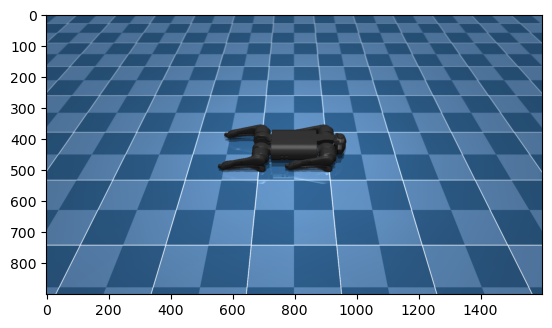

In [12]:
img = viewer.read_pixels()
plt.imshow(img)

In [13]:
# reset robot (keyframes are defined in the xml)
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 0) # stand position
mujoco.mj_forward(model_sim, data_sim)
q_ref_mj = cp.deepcopy(data_sim.qpos) # save reference pose
v_ref_mj = cp.deepcopy(data_sim.qvel) # save reference pose

In [14]:
print("Configuration: {}".format(q_ref_mj)) # save reference pose

Configuration: [ 0.    0.    0.27  1.    0.    0.    0.    0.    0.9  -1.8   0.    0.9
 -1.8   0.    0.9  -1.8   0.    0.9  -1.8 ]


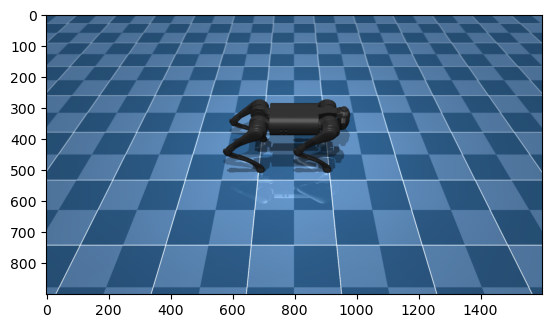

In [15]:
img = viewer.read_pixels()
plt.imshow(img)

In [16]:
controller_jax = MPPI()
controller_jax.reset_planner()

In [17]:
Q = jnp.diag(jnp.concatenate([100*jnp.ones(3),    #cost pos body
                              1000000*jnp.ones(4),      #cost attitude body
                              100*jnp.ones(12),     #cost ref feet
                              0.1*jnp.ones(18)])) #cost velocities


R = jnp.diag(0.1*jnp.ones(12))

x_ref = jnp.concatenate([q_ref_mj, v_ref_mj])

In [18]:
q_init[7:]

array([ 0.073,  1.34 , -2.83 ,  0.073,  1.34 , -2.83 ,  0.073,  1.34 ,
       -2.83 ,  0.073,  1.34 , -2.83 ])

In [28]:
params = {'seed':42,
          'h':dt_roll,
          'sample_type':'cubic',
          'n_knots':4,
          'horizon':40,
          'temperature':0.001,
          'n_samples':30,
          'noise_sigma':[0.02, 0.05, 0.09]*4,
          #'noise_sigma':[0.01, 0.01, 0.04]*4,
          'num_workers':10,
          'model':model_roll,
          'sampling_init':q_init[7:],
          'joints_ref':q_ref_mj[7:],
          'Q':Q,
          'R':R,
          'x_ref':x_ref}

In [29]:
controller_jax = MPPI(params)
controller_jax.reset_planner()

In [17]:
q_curr = cp.deepcopy(data_sim.qpos) # save reference pose
v_curr = cp.deepcopy(data_sim.qvel) # save reference pose
x = jnp.concatenate([q_curr, v_curr])

In [18]:
%%time
controller_jax.get_u(x)

CPU times: user 237 ms, sys: 33.5 ms, total: 270 ms
Wall time: 397 ms


(array([ 0.07845291,  1.31192589, -2.76719642,  0.07521226,  1.34006703,
        -2.69743419,  0.02398255,  1.26911581, -2.818     ,  0.06573479,
         1.32726967, -2.818     ]),
 Array(11320.667, dtype=float32))

In [19]:
%%time
controller_jax.get_u(x)

CPU times: user 25.8 ms, sys: 1.11 ms, total: 26.9 ms
Wall time: 11.4 ms


(array([ 0.08270355,  1.28082252, -2.55396771,  0.08256368,  1.40671813,
        -2.70534825,  0.04470893,  1.27098   , -2.69480944,  0.06595597,
         1.35620987, -2.78503013]),
 Array(10346.765, dtype=float32))

In [20]:
tfinal = 5
tvec = jnp.linspace(0,tfinal,int(jnp.ceil(tfinal/dt_sim))+1)

In [21]:
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 1)
mujoco.mj_forward(model_sim, data_sim)

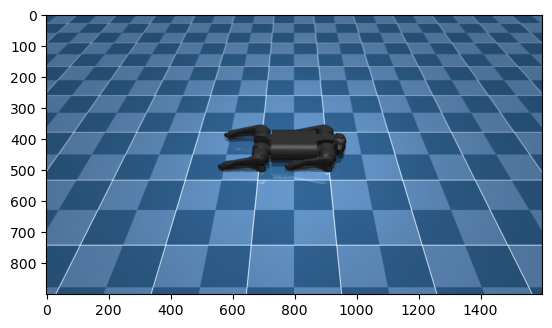

In [22]:
img = viewer.read_pixels()
plt.imshow(img)

In [23]:
%%time
anim_imgs = []
sim_inputs = []
for ticks, ti in enumerate(tvec):
    q_curr = cp.deepcopy(data_sim.qpos) # save reference pose
    v_curr = cp.deepcopy(data_sim.qvel) # save reference pose
    x = jnp.concatenate([q_curr, v_curr])
    u_joints = controller_jax.update(x)    
    data_sim.ctrl[:] = u_joints
    mujoco.mj_step(model_sim, data_sim)
    mujoco.mj_forward(model_sim, data_sim)
    img = viewer.read_pixels()
    anim_imgs.append(img)
    sim_inputs.append(u_joints)

CPU times: user 12 s, sys: 828 ms, total: 12.8 s
Wall time: 5.5 s


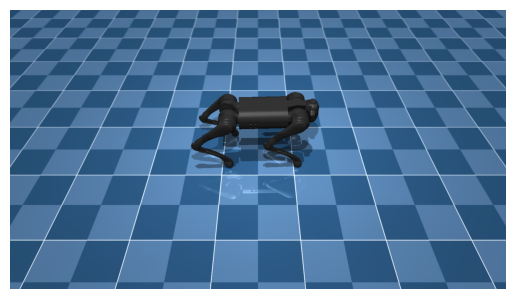

In [24]:
fig, ax = plt.subplots()
skip_frames = 10
interval = dt_sim*1000*skip_frames

def animate(i):
    ax.clear()
    ax.imshow(anim_imgs[i * skip_frames])  # Display the image, skipping frames
    ax.axis('off')

# Create animation, considering the reduced frame rate due to skipped frames
ani = FuncAnimation(fig, animate, frames=len(anim_imgs) // skip_frames, interval=interval)  # 50 ms for 20 Hz

# Display the animation
HTML(ani.to_jshtml())